In [1]:
import pandas as pd
import numpy as np
import os
import config
from joblib import dump, load
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import wilcoxon, kendalltau
from utils import plot_longitudinal, get_diversity

# Compute GMHI2 scores

In [2]:
study = "P90"

In [3]:
gmhi2 = load(os.path.join(config.MODEL_DIR, "gmhi2_model.joblib"))
gmhi2

LogisticRegression(C=0.03, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')

In [4]:
X = pd.read_csv(os.path.join(config.CLEAN_DIR, "taxonomic_features_val.csv"), index_col=[0, 1]).loc[study]
X.head()

k__Archaea  k__Archaea|p__Euryarchaeota  \
Sample Accession                                            
SAMN16701456             0.0                          0.0   
SAMN16701455             0.0                          0.0   
SAMN16701454             0.0                          0.0   
SAMN16701453             0.0                          0.0   
SAMN16701452             0.0                          0.0   

                  k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Sample Accession                                                   
SAMN16701456                                                 0.0   
SAMN16701455                                                 0.0   
SAMN16701454                                                 0.0   
SAMN16701453                                                 0.0   
SAMN16701452                                                 0.0   

                  k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Sample Accession                                                                         
SAMN16701456                                                    0.0                      
SAMN16701455                                                    0.0                      
SAMN16701454                                                    0.0                      
SAMN16701453                                                    0.0                      
SAMN16701452                                                    0.0                      

                  k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Sample Accession                                                                                                
SAMN16701456                                                    0.0                                             
SAMN16701455                                                    0.0                                             
SAMN16701454                                                    0.0                                             
SAMN16701453                                                    0.0                                             
SAMN16701452                                                    0.0                                             

                  k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
Sample Accession                                                                                                                      
SAMN16701456                                                    0.0                                                                   
SAMN16701455                                                    0.0                                                                   
SAMN16701454                                                    0.0                                                                   
SAMN16701453                                                    0.0                                                                   
SAMN16701452                                                    0.0                                                                   

                  k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
Sample Accession                                                                                                                                                    
SAMN16701456                                                    0.0                                                                                                 
SAMN16701455                                                    0.0                                                                                                 
SAMN16701454                                                    0.0                 

In [5]:
meta = pd.read_csv(os.path.join(config.CLEAN_DIR, "metadata_val.csv"), index_col=[0, 1, 2]).loc[study]
meta["GMHI2"] = gmhi2.decision_function(X > config.PRESENCE_CUTOFF)
meta.index = meta.index.get_level_values(1)
meta.head()

health_status/host_diet timepoint     GMHI2
Subject_ID                                            
9016                           EEN        12 -0.428345
9016                           EEN        11 -0.424356
9016                           EEN        10 -1.038320
9016                           EEN         9 -0.002693
9016                           EEN         8  0.126793

# Compute other indices

In [6]:
np.unique(meta["timepoint"], return_counts=True)

(array(['0', '1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5',
        '6', '7', '8', '9', 'PS'], dtype=object),
 array([18, 22, 28, 26, 27, 28, 24, 29, 25, 26, 29, 26, 29, 27, 18, 27, 19]))

In [7]:
for diet in meta["health_status/host_diet"].unique():
    d = meta[meta["health_status/host_diet"] == diet]
    s = (d["timepoint"] == "0").sum()
    print(diet)
    print(s)

EEN
9
Omnivore
9
Vegan
0


## vegan group doesn't have any day zero because they did not have a dietary intervention

In [8]:
meta = get_diversity(meta, X)
meta.head()

health_status/host_diet timepoint     GMHI2  Species Richness  \
Subject_ID                                                                 
9016                           EEN        12 -0.428345                19   
9016                           EEN        11 -0.424356                15   
9016                           EEN        10 -1.038320                18   
9016                           EEN         9 -0.002693                 2   
9016                           EEN         8  0.126793                 1   

            Shannon Diversity  Simpson Diversity  
Subject_ID                                        
9016                 1.834157           0.204109  
9016                 1.508526           0.310608  
9016                 1.834897           0.219087  
9016                 0.426438           0.015682  
9016                 0.291104           0.024803

# Plot stuff now 

In [9]:
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)
rc("svg", fonttype="none") 

In [10]:
meta["timepoint_plot"] = [16 if time == "PS" else int(time) for time in meta["timepoint"]]
meta.head()

health_status/host_diet timepoint     GMHI2  Species Richness  \
Subject_ID                                                                 
9016                           EEN        12 -0.428345                19   
9016                           EEN        11 -0.424356                15   
9016                           EEN        10 -1.038320                18   
9016                           EEN         9 -0.002693                 2   
9016                           EEN         8  0.126793                 1   

            Shannon Diversity  Simpson Diversity  timepoint_plot  
Subject_ID                                                        
9016                 1.834157           0.204109              12  
9016                 1.508526           0.310608              11  
9016                 1.834897           0.219087              10  
9016                 0.426438           0.015682               9  
9016                 0.291104           0.024803               8

In [11]:
timepoints_sorted = sorted(list(meta["timepoint"].unique()), key=lambda x : 16 if x == "PS" else int(x))
timepoints_sorted

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 'PS']

In [12]:
indices = ["GMHI2", "Species Richness", "Shannon Diversity", "Simpson Diversity"]

In [13]:
# only keep timepoints before intervention
# meta = meta.iloc[[not time == "PS" and int(time) <= 6 for time in meta['timepoint']]]
# timepoints_sorted = timepoints_sorted[:7]

/Users/daniel/opt/anaconda3/envs/data/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/daniel/opt/anaconda3/envs/data/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


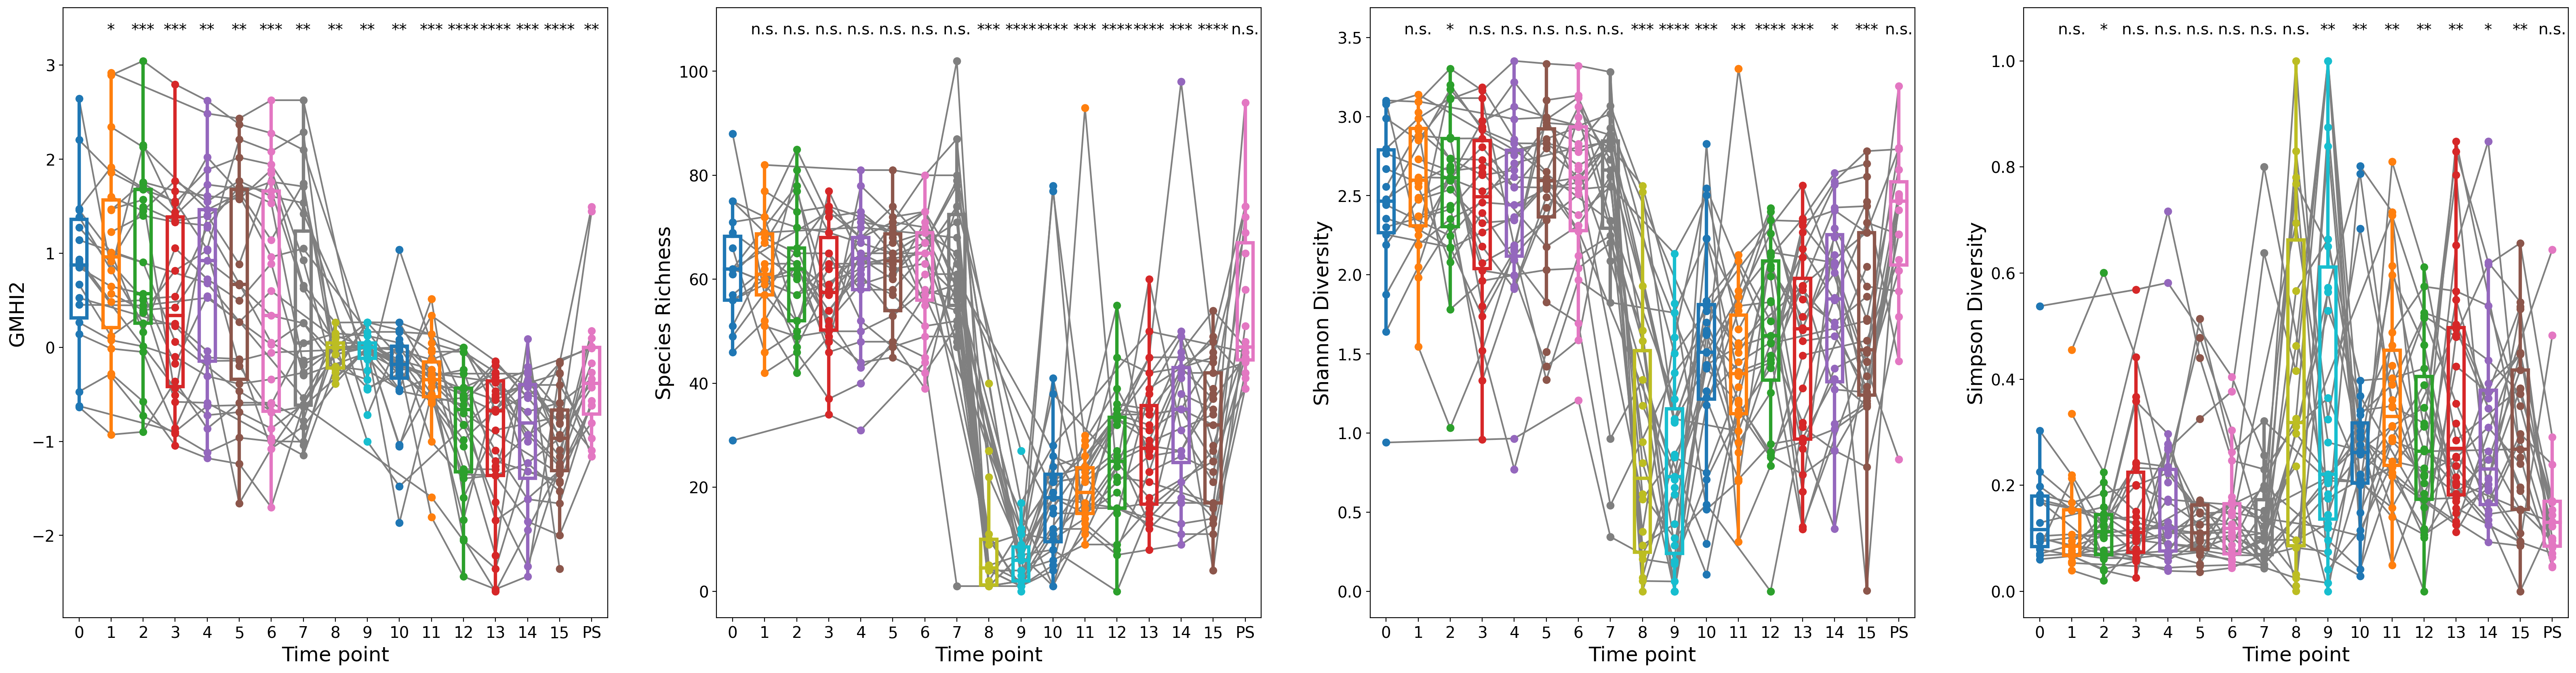

In [14]:
plot_longitudinal(meta, indices, timepoints_sorted, study, stars=True)

EEN


/Users/daniel/opt/anaconda3/envs/data/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/daniel/opt/anaconda3/envs/data/lib/python3.7/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Omnivore


/Users/daniel/opt/anaconda3/envs/data/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/daniel/opt/anaconda3/envs/data/lib/python3.7/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/daniel/opt/anaconda3/envs/data/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/daniel/opt/anaconda3/envs/data/lib/python3.7/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation."

Vegan


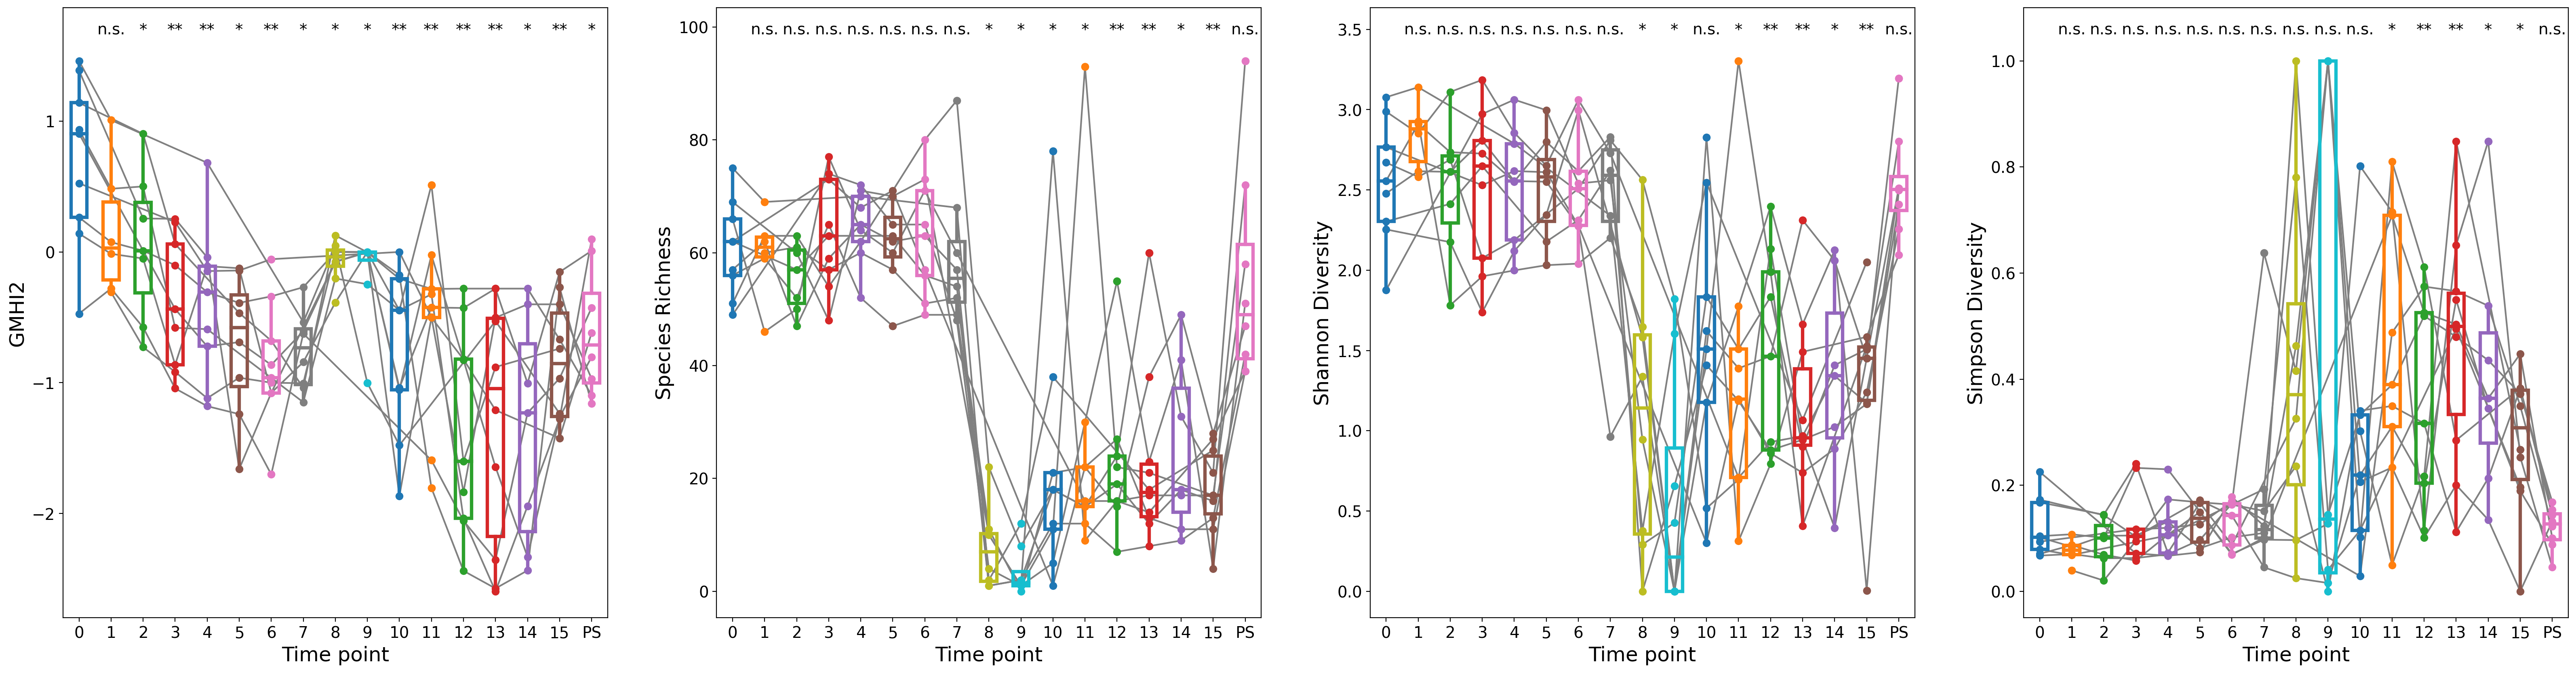

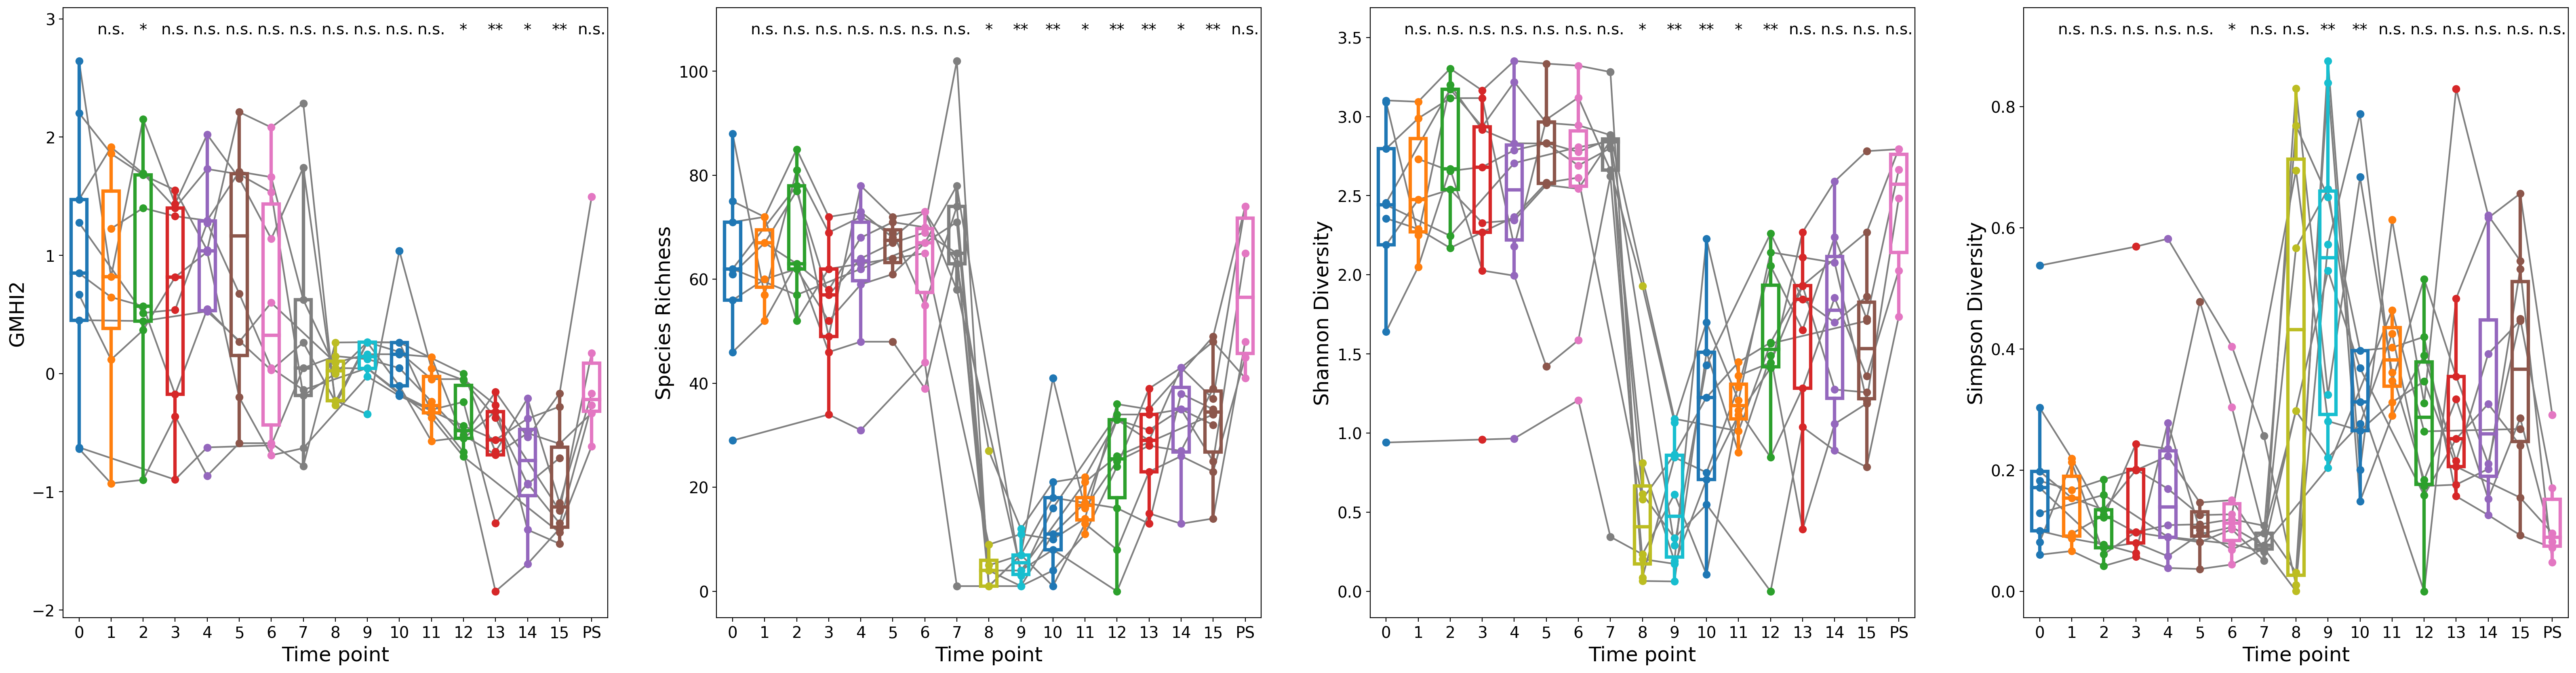

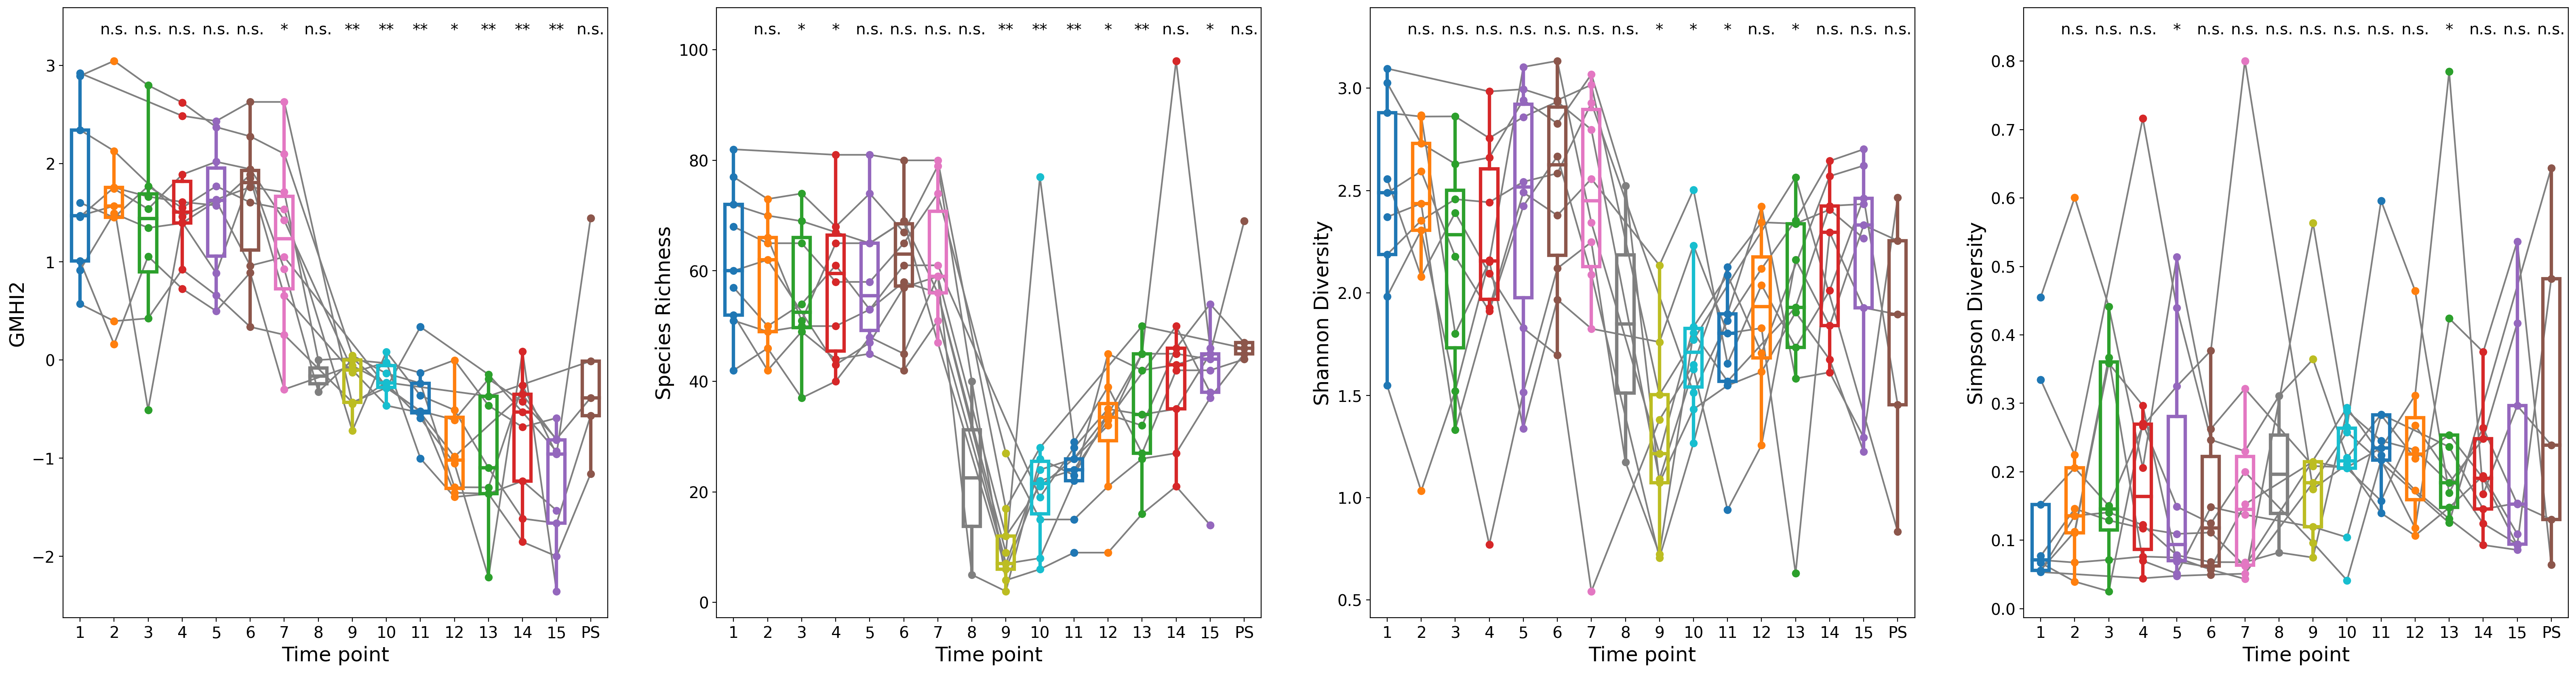

In [15]:
for diet in meta["health_status/host_diet"].unique():
    print(diet)
    timepoints_sorted_curr = timepoints_sorted
    meta_curr = meta.copy()
    
    # because vegans don't have baseline samples for some reason
    if diet == "Vegan":
        timepoints_sorted_curr = timepoints_sorted[1:]
        meta_curr['timepoint_plot'] -= 1
        
    plot_longitudinal(meta_curr[meta_curr["health_status/host_diet"] == diet], indices, timepoints_sorted_curr, study + "_" + diet, stars=True)

In [16]:
meta

health_status/host_diet timepoint     GMHI2  Species Richness  \
Subject_ID                                                                 
9016                           EEN        12 -0.428345                19   
9016                           EEN        11 -0.424356                15   
9016                           EEN        10 -1.038320                18   
9016                           EEN         9 -0.002693                 2   
9016                           EEN         8  0.126793                 1   
...                            ...       ...       ...               ...   
9003                           EEN         3 -0.579882                54   
9017                         Vegan         1  1.008245                52   
9016                           EEN        15 -0.153452                16   
9016                           EEN        14 -1.003695                18   
9016                           EEN        13 -0.280245                12   

            Shannon Diversity  Simpson Diversity  timepoint_plot  
Subject_ID                                                        
9016                 1.834157           0.204109              12  
9016                 1.508526           0.310608              11  
9016                 1.834897           0.219087              10  
9016                 0.426438           0.015682               9  
9016                 0.291104           0.024803               8  
...                       ...                ...             ...  
9003                 2.075606           0.232752               3  
9017                 2.556873           0.152206               1  
9016                 1.507728           0.189357              15  
9016                 1.408565           0.344768              14  
9016                 0.900493           0.549593              13  

[428 rows x 7 columns]

In [17]:
# sanity check the plots

for group in ["EEN", "Omnivore"]:
    for index in ["GMHI2", "Species Richness", "Shannon Diversity", "Simpson Diversity"]:
        for t in ["1", "2", "3", "4", "5", "6"]:
            a = meta[(meta["timepoint"] == "0") & (meta["health_status/host_diet"] == group)].sort_index()[index]
            b = meta[(meta["timepoint"] == t) & (meta["health_status/host_diet"] == group)].sort_index()[index]
            both = set(a.index) & set(b.index)
            a = a.loc[both]
            b = b.loc[both]
            print(wilcoxon(a, b))
        print()
    print()

WilcoxonResult(statistic=3.0, pvalue=0.3125)
WilcoxonResult(statistic=0.0, pvalue=0.03125)
WilcoxonResult(statistic=0.0, pvalue=0.0078125)
WilcoxonResult(statistic=0.0, pvalue=0.0078125)
WilcoxonResult(statistic=0.0, pvalue=0.015625)
WilcoxonResult(statistic=0.0, pvalue=0.0078125)

WilcoxonResult(statistic=7.0, pvalue=1.0)
WilcoxonResult(statistic=5.0, pvalue=0.3125)
WilcoxonResult(statistic=7.0, pvalue=0.1484375)
WilcoxonResult(statistic=8.5, pvalue=0.1953125)
WilcoxonResult(statistic=9.5, pvalue=0.46875)
WilcoxonResult(statistic=13.0, pvalue=0.546875)

WilcoxonResult(statistic=5.0, pvalue=0.625)
WilcoxonResult(statistic=2.0, pvalue=0.09375)
WilcoxonResult(statistic=16.0, pvalue=0.84375)
WilcoxonResult(statistic=10.0, pvalue=0.3125)
WilcoxonResult(statistic=13.0, pvalue=0.9375)
WilcoxonResult(statistic=15.0, pvalue=0.7421875)

WilcoxonResult(statistic=7.0, pvalue=1.0)
WilcoxonResult(statistic=2.0, pvalue=0.09375)
WilcoxonResult(statistic=18.0, pvalue=1.0)
WilcoxonResult(statistic=14.0

/Users/daniel/opt/anaconda3/envs/data/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/daniel/opt/anaconda3/envs/data/lib/python3.7/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
